In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

from torch import nn
import torch
import glob

from sklearn.model_selection import train_test_split
from tools import AverageMeter

GENERATIVE_MODEL_PATH = 'generative_model'

# TME RNN
Dans ce TME je implemente deux modules de RNN : un pour generation et l'autre pour classification.

## Name generation
On crée une module de RNN qui travaille avec les character (character level RNN) pour generer les nouveaux noms. En On utilise un dataset de noms et on prendre que un langue à la fois.
Voila la definition du module et les 'helpers' necessaires.

In [19]:
class RNN(nn.Module):

    def __init__(self, hidden_n, vocab_n):
        super().__init__()
        self.whh = nn.Linear(in_features=hidden_n, out_features=hidden_n, bias=False)
        self.wxh = nn.Linear(in_features=vocab_n, out_features=hidden_n, bias=True)
        self.why = nn.Linear(in_features=hidden_n, out_features=vocab_n, bias=True)
        
    def forward(self, h, x):
        # update the hidden state
        whhh = self.whh(h)
        wxhx = self.wxh(x)
        h_ = torch.tanh(whhh + wxhx)
        # compute the output vector
        y = self.why(h_)
        return h_, y

def read_data(languages=None):
    dataframes = []
    for path in glob.glob("data/names/*.txt"):
        classname = path.split('/')[-1].split('.')[0]
        abspath = os.path.abspath(path)
        names = pd.read_csv(abspath, header=None)
        names['label'] = [classname] * names.shape[0]
        dataframes.append(names)
    data = pd.concat(dataframes)

    data['X'] = data[0].apply(str.lower)

    vocab = set([char for char in ''.join(data.X.values.tolist())])
    SEQUENCE_END = '_'
    NULL_VALUE = '0'
    vocab.add(SEQUENCE_END)
    vocab.add(NULL_VALUE)

    vocab2int = dict(zip(vocab,np.arange(len(vocab))))

    appended = data.X + '_'
    converted = appended.apply(lambda name : [vocab2int[c] for c in name])
    data['converted'] = converted
    
    classes = set(data.label)
    if languages:
        filters = [data.label == lang for lang in languages]
        data = data[np.logical_or.reduce(filters)]

    class2int = dict(zip(classes, np.arange(len(classes))))
    data['class_target'] = data.label.apply(lambda cls : class2int[cls])
    return data, vocab, vocab2int, class2int

class NameDataset(Dataset):

    def __init__(self, data, vocab, vocab2int):
        """
        """
        self.data, self.vocab, self.vocab2int = data, vocab, vocab2int
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        example = self.data.iloc[idx]
        x = np.array(example["converted"])
        y = np.array(example["class_target"])
        return torch.from_numpy(x).to(device), torch.from_numpy(y).to(device)

def add_padding(text, pad, pad_size=21, pad_end=True):
    length = text.shape[0]
    if length < pad_size:
        padding = torch.tensor(np.array(pad), device=device) * torch.ones(pad_size - length, device=device).long()
        order = (text, padding) if pad_end else (padding, text)
        padded_text = torch.cat(order)  
    else:
        padded_text = text
    return padded_text

def collate_fn(data, pad_end = True):
    lengths = []
    X = []
    Y = []
    for x, target in data:
        X.append(add_padding(x, vocab2int['0'], pad_end=pad_end).reshape(1,-1,))
        Y.append(target.reshape(1,-1))
    X = torch.cat(X)
    Y = torch.cat(Y)
    mask = (X > 0).float()
    lengths = mask.sum(1)
    order = np.argsort(lengths.cpu().numpy())[::-1].copy()
    #mask[mask == 0] = -1
    return X[order],Y[order],mask[order],lengths[order]

def onehot_label(dico, value):
    y_onehot = np.zeros((len(dico),1))
    y_onehot[class2int[value]] = 1
    return y_onehot
    
torch.cuda.set_device(0)
device = torch.device('cuda')

def get_dataloaders(languages=None):
    data, vocab, vocab2int, class2int = read_data(languages=languages)
    
    train_data, test_val_data = train_test_split(data, test_size=0.3)
    test_data, val_data = train_test_split(test_val_data, test_size=0.33)

    batch_size = 64

    train_data_loader = DataLoader(NameDataset(train_data, vocab, vocab2int),
                                   batch_size=batch_size,shuffle=True, collate_fn=collate_fn)

    test_data_loader = DataLoader(NameDataset(test_data, vocab, vocab2int),
                                   batch_size=batch_size,shuffle=True, collate_fn=collate_fn)

    val_data_loader = DataLoader(NameDataset(val_data, vocab, vocab2int),
                                   batch_size=batch_size,shuffle=True, collate_fn=collate_fn)
    
    loaders = (train_data_loader, test_data_loader, val_data_loader)
    vocabulary = (data, vocab, vocab2int, class2int)
    return loaders, vocabulary

(train_data_loader, test_data_loader, val_data_loader),(data, vocab, vocab2int, class2int) = get_dataloaders(languages=['English'])

En suite on repete 100 epoch d'apprentissage avec taille de l'état caché 100 et taille un patch 64. On utilise zero-padding et un mask pour identifier les examples presentes.

In [20]:
vocab_n = len(vocab)
hidden_n = 100
#langs = np.unique(data.class_target).shape[0]
rnn = RNN(hidden_n=hidden_n, vocab_n=vocab_n).to(device=device)

def train_rnn(rnn, train_data_loader_, val_data_loader_, print_loss = False):
    criterion = nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.Adam(rnn.parameters())

    training_losses = []
    test_losses = []
    training_loss = AverageMeter()
    test_loss = AverageMeter()
    for epoch in range(100):
        training_loss.reset()
        test_loss.reset()

        # TRAINING
        for index, (name, label, mask, _) in enumerate(train_data_loader_):
            batch_size = name.shape[0]

            x_onehot = torch.FloatTensor(len(name), name.shape[1], vocab_n).to(device=device)
            x_onehot.zero_()
            x_onehot.scatter_(2, name.unsqueeze(2), 1)    

            output = []
            hx = torch.zeros(hidden_n).to(device=device).float()
            for i in range(name.shape[1] - 1):
                hx,y_pred = rnn(hx, x_onehot[:, i,:])
                output.append(y_pred)

            optimizer.zero_grad()
            for i in reversed(range(1,name.shape[1])):
                y_pred = output[i-1]
                y_char = x_onehot[:, i, :].argmax(dim=1)

                current_mask = mask[:,i]

                loss = criterion(y_pred, y_char.long())
                present_losses = (loss * current_mask).mean()

                training_loss.update(present_losses.item())

                not_last_char = i > 0
                present_losses.backward(retain_graph=not_last_char)
            optimizer.step()

        # EVALUATION
        with torch.no_grad():
            if epoch % 2 == 0:
                for index, (name, label, mask, _) in enumerate(val_data_loader_):
                    batch_size = name.shape[0]

                    x_onehot = torch.FloatTensor(len(name), name.shape[1], vocab_n).to(device=device)
                    x_onehot.zero_()
                    x_onehot.scatter_(2, name.unsqueeze(2), 1)    

                    output = []
                    hx = torch.zeros(hidden_n).to(device=device).float()
                    for i in range(name.shape[1] - 1):
                        hx,y_pred = rnn(hx, x_onehot[:, i,:])
                        output.append(y_pred)

                    # Decoding
                    # loss and gradient update from hx & y

                    for i in reversed(range(1,name.shape[1])):
                        y_pred = output[i-1]
                        y_char = x_onehot[:, i, :].argmax(dim=1)

                        current_mask = mask[:,i]
                        loss = criterion(y_pred, y_char.long())
                        present_losses = (loss * current_mask).mean()
                        test_loss.update(present_losses.item())

                test_losses.append(test_loss.avg)
        if print_loss:
            print(training_loss.avg)
        training_losses.append(training_loss.avg)
    return rnn, training_losses, test_losses
    
rnn, training_losses, test_losses = train_rnn(rnn, train_data_loader, val_data_loader) 
torch.save(rnn.state_dict(), GENERATIVE_MODEL_PATH)

Dans le plot suivant nous visualisons l'erreur moyenne pour chaque patch. On peut noter, que l'erreur de train pourrait encore diminuer, si on apprends plus des epochs, mais il commence éloigner de l'erreur du test.

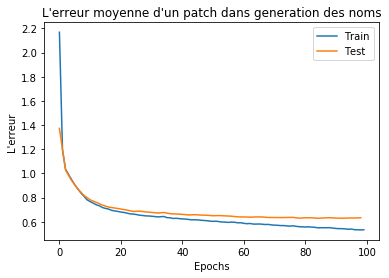

In [21]:
def print_losses(training_losses_, test_losses_):
    plt.title("L'erreur moyenne d'un patch dans generation des noms")
    plt.plot(np.arange(len(training_losses_)), training_losses_, label="Train")
    plt.plot(np.arange(len(test_losses_)) * 2, test_losses_, label="Test")
    plt.ylabel("L'erreur")
    plt.xlabel('Epochs')
    plt.legend()

print_losses(training_losses, test_losses)

# Classification
Nous allons maintenant classifier les noms selon des langues. On utilise la méme modèle, que pour generation, mais on va mettre en jour la gradient seulement aprés parcourir tous les characters d'un nom, en utilisant le langue comme label.

In [15]:
class ClassificationRNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.whh = nn.Linear(in_features=hidden_size, out_features=hidden_size, bias=False)
        self.wxh = nn.Linear(in_features=input_size, out_features=hidden_size, bias=True)
        self.why = nn.Linear(in_features=hidden_size, out_features=output_size, bias=True)
        
    def forward(self, h, x):
        # update the hidden state
        whhh = self.whh(h)
        wxhx = self.wxh(x)

        h_ = torch.tanh(whhh + wxhx)
        # compute the output vector
        y = self.why(h_)
        return h_, y

In [16]:
# Padding au debut
collate_fn_pad_begin = lambda data: collate_fn(data, pad_end=False)
data, vocab, vocab2int, class2int = read_data()

train_data, test_val_data = train_test_split(data, test_size=0.3)
test_data, val_data = train_test_split(test_val_data, test_size=0.33)

batch_size = 128

train_data_loader = DataLoader(NameDataset(train_data, vocab, vocab2int),
                               batch_size=batch_size,shuffle=True, collate_fn=collate_fn_pad_begin)

test_data_loader = DataLoader(NameDataset(test_data, vocab, vocab2int),
                               batch_size=batch_size,shuffle=True, collate_fn=collate_fn_pad_begin)

val_data_loader = DataLoader(NameDataset(val_data, vocab, vocab2int),
                               batch_size=batch_size,shuffle=True, collate_fn=collate_fn_pad_begin)

vocab_n = len(vocab)
hidden_n = vocab_n
langs = np.unique(data.class_target).shape[0]
rnn = ClassificationRNN(input_size=vocab_n, hidden_size=hidden_n, output_size=langs).to(device=device)

criterion = nn.CrossEntropyLoss()#reduction='none')
optimizer = torch.optim.Adam(rnn.parameters())

training_losses = []
test_losses = []
scores = []
training_loss = AverageMeter()
test_loss = AverageMeter()
for epoch in range(100):
    training_loss.reset()
    test_loss.reset()
    
    # TRAINING
    for index, (name, label, mask, lengths) in enumerate(train_data_loader):
        batch_size = name.shape[0]
        
        x_onehot = torch.FloatTensor(len(name), name.shape[1], vocab_n).to(device=device)
        x_onehot.zero_()
        x_onehot.scatter_(2, name.unsqueeze(2), 1)
        
        hx = torch.zeros(hidden_n).to(device=device).float()
        for i in range(name.shape[1] - 1):
            x = x_onehot[:,i,:]
            hx, y_pred = rnn(hx, x)

        # Decoding
        # loss and gradient update from hx & y

        optimizer.zero_grad()
        
        loss = criterion(y_pred, label.reshape(-1))
        #import pdb; pdb.set_trace()
        #present_losses = (loss * current_mask).mean()

        training_loss.update(loss.item())

        loss.backward()
        optimizer.step()
        
    # EVALUATION
    with torch.no_grad():
        if epoch % 2 == 0:
            score = 0
            total = 0
            for index, (name, label, mask, lengths) in enumerate(val_data_loader):
                batch_size = name.shape[0]

                x_onehot = torch.FloatTensor(len(name), name.shape[1], vocab_n).to(device=device)
                x_onehot.zero_()
                x_onehot.scatter_(2, name.unsqueeze(2), 1)    
                
                hx = torch.zeros(hidden_n).to(device=device).float()
                for i in range(name.shape[1] - 1):
                    x = x_onehot[:,i,:]
                    hx, y_pred = rnn(hx, x)

                # Decoding
                # loss and gradient update from hx & y
                loss = criterion(y_pred, label.long().reshape(-1))
                
                #import pdb; pdb.set_trace()
                score += (y_pred.argmax(1).reshape(-1) == label.reshape(-1)).sum()
                total += batch_size
                
                test_loss.update(loss.item())
            
            acc = score.cpu().item() / total
            #print(acc)
            scores.append(acc)
            test_losses.append(test_loss.avg)
    #print(training_loss.avg)
    training_losses.append(training_loss.avg)

Nous arrivons environ au accuracy 0.8, qui n'est pas mal avec 18 classes (les langues differents).

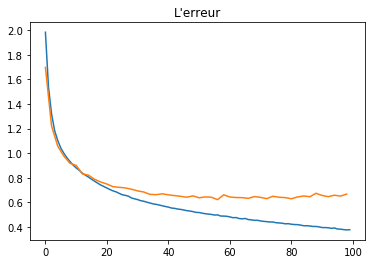

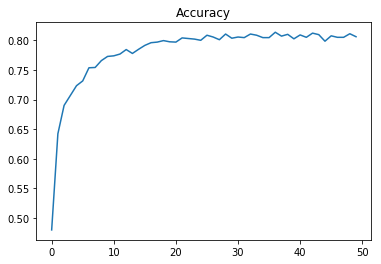

In [18]:
plt.figure()
plt.title("L'erreur")
plt.plot(np.arange(len(training_losses)), training_losses, label="Train")
plt.plot(np.arange(len(test_losses)) * 2, test_losses, label="Test")


plt.figure()
plt.title('Accuracy')
plt.plot(np.arange(len(scores)),scores)

# BEAM SEARCH
https://en.wikipedia.org/wiki/Beam_search

Avec generation, on a probleme que souvent le RNN commence repeter les mémes characters. À lieu de choisir chaque fois le character le plus propable à la facon glouton, on peut aussi essayer travailler avec les probabilites de chaque character et maximiser le vraiesemblance. Pour limiter les calcules, on utilise Beam Search.

In [74]:
class BeamSearch():
    
    def __init__(self, model, hx, y_pred,int2vocab, memory_capacity = 20):
        self.capacity = memory_capacity
        self.memory_chars_probas = torch.zeros(memory_capacity, 58).to(device)
        self.memory_hx = torch.zeros(memory_capacity, len(hx)).to(device)
        self.memory_probas = np.zeros(memory_capacity)
        self.memory_chars = {}
        self.rnn = model
        self.y_pred = y_pred
        self.int2vocab = int2vocab
        
        for i in range(memory_capacity):
            hist = [int2vocab[y_pred.argmax().cpu().item()]]
            self.memory_chars[i] = hist
        
        self.memory_chars_probas[:] = y_pred
        self.memory_hx[:] = hx
        
    def update(self):
        cache = {}
        probas = np.zeros(self.capacity * 58)
        for old_char_idx, (char, old_proba, hx) in enumerate(
                zip(self.memory_chars_probas, self.memory_probas, self.memory_hx)):
            history = self.memory_chars[old_char_idx]
            hx,y_pred = self.rnn(hx, char)
            #eimport pdb; pdb.set_trace()
            log_probas = torch.log(torch.sigmoid(y_pred)).cpu().numpy()
            
            new_probas = log_probas + old_proba
            for next_char_idx in range(log_probas.shape[0]):
                next_char = self.int2vocab[next_char_idx]
                global_idx = (old_char_idx * 58) + next_char_idx
                probas[global_idx] = new_probas[next_char_idx]
                hist = history.copy()
                hist.append(next_char)
                cache[global_idx] = (hist,hx, y_pred)
            
            #_, idx = torch.sort(log_probas)
            
        # REMOVE DUPLICATES 
        unique_set = set()
        minimum = probas.min() - 1 # smaller than minimum
        for cache_idx in range(probas.shape[0]):
            name = ''.join(cache[cache_idx][0])
            if name in unique_set: # got name allready, remove this one
                probas[cache_idx] = minimum
            unique_set.add(name)
                
        #import pdb; pdb.set_trace()
        top_k = probas.argsort()[::-1][:self.capacity]
        for i, global_i in enumerate(top_k):
            history,hx, y_pred = cache[global_i]
            
            self.memory_chars_probas[i] = y_pred
            self.memory_hx[i] = hx
            self.memory_probas[i] = probas[global_i]
            self.memory_chars[i] = history
            
        return (self.memory_probas, self.memory_chars)
    
    def get_best(self):
        return ''.join(self.memory_chars[self.memory_probas.argmax()])


vocab_n = len(vocab)
hidden_n = 100

rnn = RNN(hidden_n=hidden_n, vocab_n=vocab_n).to(device=device)
rnn.load_state_dict(torch.load(GENERATIVE_MODEL_PATH))
rnn.eval()

int2vocab = dict(zip(vocab2int.values(),vocab2int.keys()))
with torch.no_grad():
    hx = torch.zeros(hidden_n).to(device=device).float()
    vec = np.zeros(len(vocab2int))
    char = 's'
    vec[vocab2int[char]] = 1
    y_pred = torch.from_numpy(vec).to(device).float()
    beam_search = BeamSearch(rnn, hx, y_pred, int2vocab)
    for _ in range(10):
        beam_search.update()
    print(beam_search.get_best())

stlalemanan


À lieu du repeter, avec BeamSearch on arrive produire les noms plus realistes.

# Classification avec generatif
Nous pouvons utiliser la modèle generatif pour classifier des noms. Il faut apprendre une modèle pour chaque classe. Pour simplifier le tache, je vais essayer seulement avec deux classes : les noms francais et les noms italiennes.

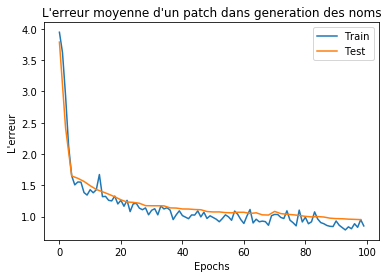

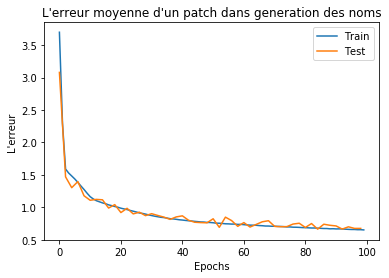

In [10]:
vocab_n = len(vocab)
hidden_n = 100

loaders_fr, vocabulary = get_dataloaders(languages=['French'])
(train_fr, test_fr, val_fr) = loaders_fr
loaders_it, vocabulary = get_dataloaders(languages=['Italian'])
(train_it, test_it, val_it) = loaders_it

rnn_fr = RNN(hidden_n=hidden_n, vocab_n=vocab_n).to(device=device)
rnn_it = RNN(hidden_n=hidden_n, vocab_n=vocab_n).to(device=device)

rnn_fr, training_losses, test_losses = train_rnn(rnn_fr, train_fr, val_fr)
print_losses(training_losses, test_losses)
plt.figure()
rnn_it, training_losses, test_losses = train_rnn(rnn_it, train_it, val_it)
print_losses(training_losses, test_losses)

In [13]:
class GenerativeClassifier:
    
    def __init__(self, models, model_names, hidden_n = 100):
        self.models = {}
        for name, model in zip(model_names, models):
            self.models[name] = model
        self.hidden_n = hidden_n
            
    def predict(self, names):
        with torch.no_grad():
            batch_size = names.shape[0]

            x_onehot = torch.FloatTensor(len(names), names.shape[1], vocab_n).to(device=device)
            x_onehot.zero_()
            x_onehot.scatter_(2, names.unsqueeze(2), 1)

            langs = list(self.models.keys())
            int2lang = dict(zip(np.arange(len(langs)), langs))
            probas = torch.zeros(names.shape[0], len(langs)).to(device)
            
            for lang_idx, model_name in enumerate(langs):
                last_prediction = None
                hx = torch.zeros(self.hidden_n).to(device=device).float()
                for i in range(names.shape[1] - 1):
                    char_embed = x_onehot[:, i,:]
                    char = char_embed.argmax(1)
                    hx,y_pred = self.models[model_name](hx, char_embed)
                    y_pred = torch.softmax(y_pred, dim=1)
                    if i > 0:
                        
                        proba = last_prediction[np.arange(char.shape[0]), char]
                        log_proba = torch.log(proba)
                        probas[:, lang_idx] += log_proba
                    last_prediction = y_pred
            
            return probas.min(dim=1)[1], int2lang
        
    def score(self, names, labels):
        preds = self.predict(names)[0]
        preds = preds.cpu().numpy()
        preds = preds.reshape(preds.shape[0])
        matches = preds == labels[0]
        return matches.sum() / matches.shape[0]

                    #output.append(y_pred)

clf = GenerativeClassifier(models=[rnn_fr, rnn_it], model_names=['fr', 'it'])

loaders_fr_it, vocabulary = get_dataloaders(languages=['French', 'Italian'])
test_data = vocabulary[0]
X = []
for name, x, target in test_data[['X','converted', 'class_target']].values:
    x = torch.from_numpy(np.array(x)).to(device)
    X.append(add_padding(x, vocab2int['0'], pad_end=False).reshape(1,-1,))

X = torch.cat(X)

Y = pd.factorize(test_data.label)
clf.score(X,Y)

0.7190669371196755

On arrive classifier les noms francais et italiennes avec probabilite 0.719, quand on utilise le modèle generatif. C'est pire que avec une modéle discriminatif auparavant (0.8 avec 18 classes).